In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

# Random forests on mouse phenotype data

Today we will use one of the most popular supervised learning methods: random forests. It is an ensemble method, which means it uses multiple predictors and makes its final prediction based on a democratic vote of its individual predictors.

These sub-predictors are called decision trees, hence the name forest. Decision trees are labelled binary trees. Every leaf is associated with a class label, and every branching point is a test for a feature-value pair: if the feature is larger than the value, the sample is passed on towards the left branch, otherwise it continues on the right branch. The prediction is the label of the leaf it eventually reaches, starting from the tree's root.

Random forests generate a set of decision trees in a structured manner, and aggregate their results. Let's see

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import metrics as sme
from sklearn.preprocessing import StandardScaler
from sklearn import tree

In [3]:
pheno = pd.read_csv('files/phenotype_cd_hfd.csv', index_col=0)
target = pheno['diet'].replace('CD', 0).replace('HFD', 1)


In [4]:
data = pheno.dropna(axis=1).drop(columns=['strain', 'diet'])

### 1.1 Use a random forest classifier
Initialize it with default settings. Show its biased performance by fitting and predicting on the entire dataset, and then show its real accuracy using a proper cross-validation. For cross-validation, use the one-liner form with yesterday's convencience function.

Then try the same with standardized input data (no need to do it fold-by-fold), and report your findings.

In [5]:
#Random forest classifier
clf_rf = RandomForestClassifier()
clf_rf.fit(data, target)

#Score on training data
clf_rf.score(data, target)

0.9911504424778761

In [6]:
#Tested with corss validation
cross_val_score(clf_rf, data, target, cv = StratifiedKFold(3, shuffle=True)).mean()

0.8935514461830252

In [7]:
#Again use the StandardScaler object
scaler = StandardScaler()
scaler.fit(data)
data_standardized = scaler.fit_transform(data)

cross_val_score(clf_rf, data_standardized, target, cv = StratifiedKFold(3, shuffle=True)).mean()

0.9030346135609294

Obviosly random forest classifier don't care if the inpute data is standardized or not, since the results are about the same. 

### 1.1.2 Determine the uncertainty of the accuracy by bootstrapping
You must have noticed that the cross-validated accuracy of the model isn't exact: it depends on the particular folds that you get during cross-validation.
If you have `shuffling` enabled, your folds will be different each time. So by repeating cross-validation many times, you could get a clearer idea of the model's accuracy by taking the average, or better yet, looking at the distribution of the individual accuracy figures.

Use 100 repeats and plot the histogram of the resulting accuracy values. What is the 90% confidence interval of the model's accuracy? (What is a confidence interval to begin with?)

In [8]:
#Collect accuracy values of 100 predictions
accuracyVals = []
for i in range(100):
    accuracyVals.append(cross_val_score(clf_rf, data, target, cv = StratifiedKFold(3, shuffle=True)).mean())

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


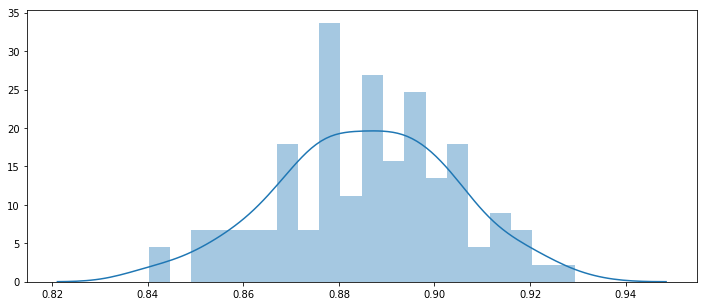

In [9]:
#Plot the distribution of those accuracy values
plt.subplots(figsize=(12,5))
plt1 = sns.distplot(accuracyVals, bins=20, hist=True)

Accuracy distribution looks normal distributed, which is good.

In [10]:
lowerBound = np.percentile(accuracyVals, 5)
upperBound = np.percentile(accuracyVals, 95)

print('Lower bound: '+ str(lowerBound))
print('Upper bound: '+ str(upperBound))

Lower bound: 0.8571597913703178
Upper bound: 0.912221431958274


90% confidence intervall is the interval where your real accuracy lays with a 90% chance.
So if we look at the histogram the true accuracy of our randomforest classifier lies with a 90% chance between 0.8486 and 0.9126.

### 1.2 Extract prediction probabilities instead of labels
`RandomForestClassifier`s have a `predict_proba` method by default, similar to `SVC`s with `proability=True` turned on. Use the convencience one-liner to get cross-validated class membership probability estimates for each sample. Create a histogram using the probability values for class `1`, but separate them by the true label of the samples, and color the two labels differently.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


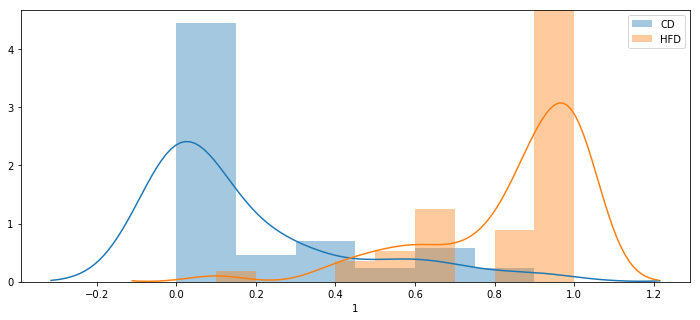

In [11]:
#Extract probability values by using method = predict_proba
probas = cross_val_predict(clf_rf, data, target, cv = StratifiedKFold(3, shuffle=True), method='predict_proba')
probas_df = pd.DataFrame(probas, index = target.index)

plt.subplots(figsize=(12,5))

#Plot two histograms, one for each class
sns.distplot(probas_df.loc[target==0, 1], hist=True, label = 'CD')
sns.distplot(probas_df.loc[target==1, 1], hist=True, label = 'HFD')
plt.legend()
plt.show()


### 1.2.2 Look at the numeric probability values. Why are they so rough?
Find out what they are derived from, and try to increase their resolution.

In [12]:
probas_df.loc[:,1].head(15)

0     0.0
1     0.4
2     0.0
3     0.9
4     0.0
5     1.0
6     0.1
7     0.8
8     0.2
9     0.1
10    0.6
11    0.9
12    0.2
13    1.0
14    0.3
Name: 1, dtype: float64

For the default parameter 'None' the trees goes so deep, so that every value is stored in one single leaf and that's why the probabilities are so rough. If the max_depth is set than the values aren't necessarily crisp anymore because more "end values" can be stored in one leaf and then you get the accumulated value.
The resolution can be increased by using more trees by put a higher number for the n_estimators parameter.

### 1.3 Create a ROC curve
Now that you know how to access the continuous internal prediction variables (class membership probability in this case) you can create a ROC plot easily.

In [13]:
fpr, tpr, thresholds = sme.roc_curve(target, probas_df.loc[:,1])
fpr, tpr, thresholds

(array([0.        , 0.03508772, 0.03508772, 0.07017544, 0.12280702,
        0.15789474, 0.1754386 , 0.26315789, 0.33333333, 0.49122807,
        1.        ]),
 array([0.41071429, 0.67857143, 0.76785714, 0.82142857, 0.89285714,
        0.94642857, 0.98214286, 0.98214286, 0.98214286, 1.        ,
        1.        ]),
 array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]))

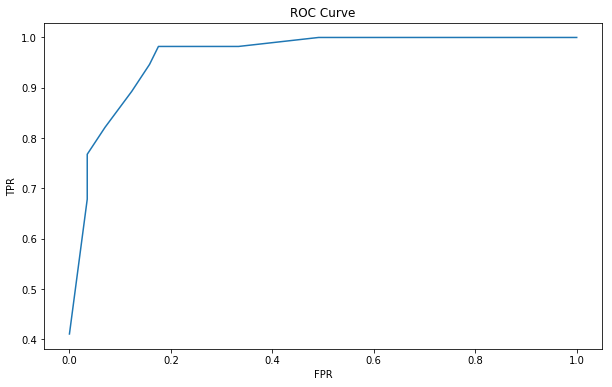

In [14]:
plt.subplots(figsize=(10,6))

roc_curce = plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

### 1.4 Visualize a decision tree
Pick any decision tree from the random forest, export it in `DOT` format using `sklearn.tree.export_graphviz` and visualize it with an online tool.

In [15]:
#Straight forward took the first decision tree
dtree = clf_rf.estimators_[1]
tree.export_graphviz(dtree, out_file='tree.dot') 

Can be visualized for example on the web page http://webgraphviz.com/.

### 1.5 Feature importances
Random forests utilize their internal structure not just to provide probability estimates, but also to estimate the importance of different features. How do you think it's done? Find a way to access the values, and present them on a bar plot, sorted by importance.

By the way, do you have to use cross-validation for feature importance estimates?

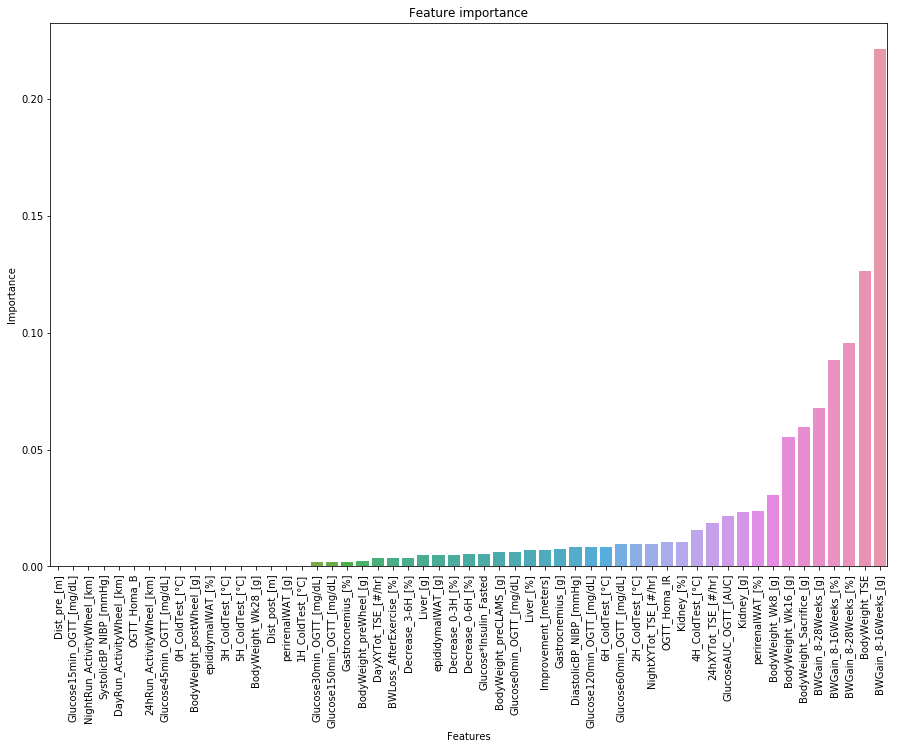

In [16]:
#Build dataframe from fetaures
features = pd.DataFrame(clf_rf.feature_importances_, index = data.columns)

#Sort them and plot them afterwards
features = features.sort_values(0)

fig, ax = plt.subplots(figsize=(15,10))


bplot = sns.barplot(x = features.index, y = features[0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title("Feature importance")
plt.show()

For the tree weights the algorithm checks how many tress decide upon the same attribute. If most of the independant tress look for the weight, then weight is obviously important and thus has a big weight. 
The bodyweight-features clearly dominate the importance, especially the first three, which all encode for the bw gain.

### 1.6 Choose 3 features, and evaluate the model using only those features
Try to choose them with accuracy in mind. Treat it as a challenge: which 3 to choose to get the best model? What was your strategy?

In [17]:
#Pick the three highest scoring features
importantFeatures_high = ['BWGain_8-16Weeks_[%]','BWGain_8-16Weeks_[g]','Gastrocnemius_[%]']
data_important_high = data.loc[:, importantFeatures_high]

cross_val_score(clf_rf, data_important_high, target, cv = StratifiedKFold(3, shuffle=True)).mean()


0.9198672356567094

One could think that picking the three most important features leads to the best results. But since most of the really high scoring features are weight stuff this isn't true because those all are correlated. By picking the three highest scoring features which are all independant in most cases it is possible to achieve better results. 

In [18]:
#Pick the three highest scoring features which are , or at least which sound, uncorrelated
importantFeatures = ['BWGain_8-16Weeks_[g]','perirenalWAT_[g]','Glucose120min_OGTT_[mg/dL]']
data_important = data.loc[:, importantFeatures]

cross_val_score(clf_rf, data_important_high, target, cv = StratifiedKFold(3, shuffle=True)).mean()


0.9030346135609294

With changing to independant features it was possible to pump the accuracy up 4%.

### 1.7 Feature clustering
Plot a clustermap of your data: it's not too big, 113x55 so you can keep all rows and columns and still have a readable figure with all feature labels if you increase its width a bit.

Should you plot the raw or the normalized data?


What patterns do you see? Are they relevant to the previous task?

In [19]:
#Use not standardized data

data_df = pd.DataFrame(data, index=target.index, columns=data.columns)

# to color the labels
data_df['is_hfd'] = target
data_df['is_hfd'] = data_df['is_hfd'].replace(True, "b")
data_df['is_hfd'] = data_df['is_hfd'].replace(False, "y")

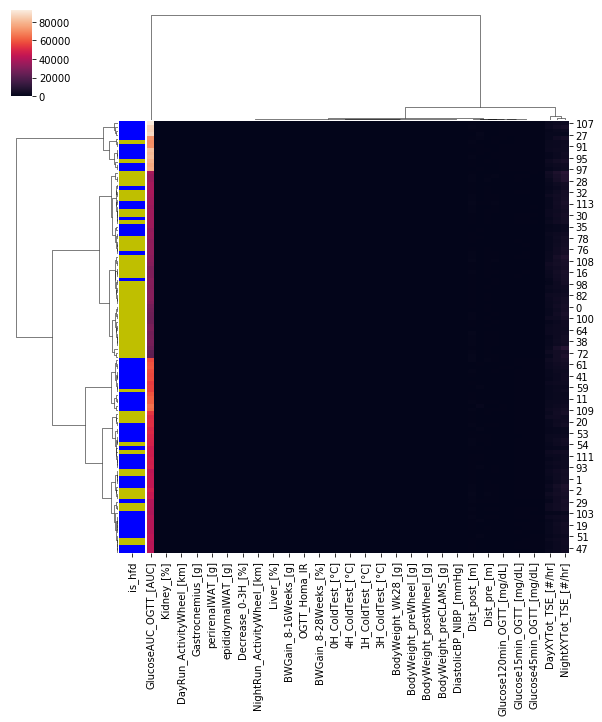

In [20]:
# Plot clustermap
cmap_raw = sns.clustermap(data_df.iloc[:,:-1], row_colors=data_df['is_hfd'], method = "ward")

This first plot is from the raw data. Because of the massive important differences between the first feature and every other feature this will bias the plot heavily. That's why we need to standardize the data.

In [21]:
#Use standartized data

data_standardized_df = pd.DataFrame(data_standardized, index=target.index, columns=data.iloc[:,:-1].columns)

# to color the labels
data_standardized_df['is_hfd'] = target
data_standardized_df['is_hfd'] = data_standardized_df['is_hfd'].replace(True, "b")
data_standardized_df['is_hfd'] = data_standardized_df['is_hfd'].replace(False, "y")

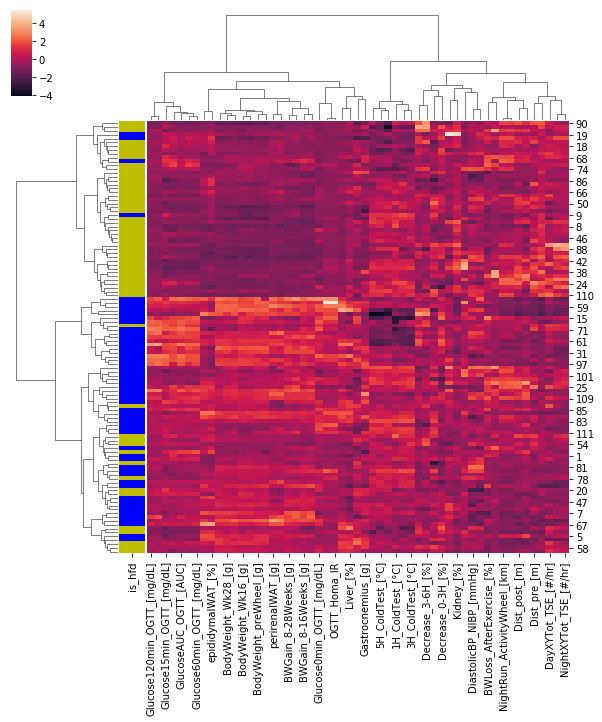

In [22]:
# Plot clustermap
cmap_standard = sns.clustermap(data_standardized_df.iloc[:,:-1], row_colors=data_standardized_df['is_hfd'], method = "ward")

This correlation map is way better. One can recognice several correlating feature groups, like for example the body weight related ones all correlate very well within each other but also very nicely with the features dealing with the glucose level. Those features are on the left side of the plot and also clusteres after diet type.

### 1.7.2 Feature correlations
Calculate correlations between your features, and visualize them on a heatmap. Would it be useful to include the diet as an extra column?

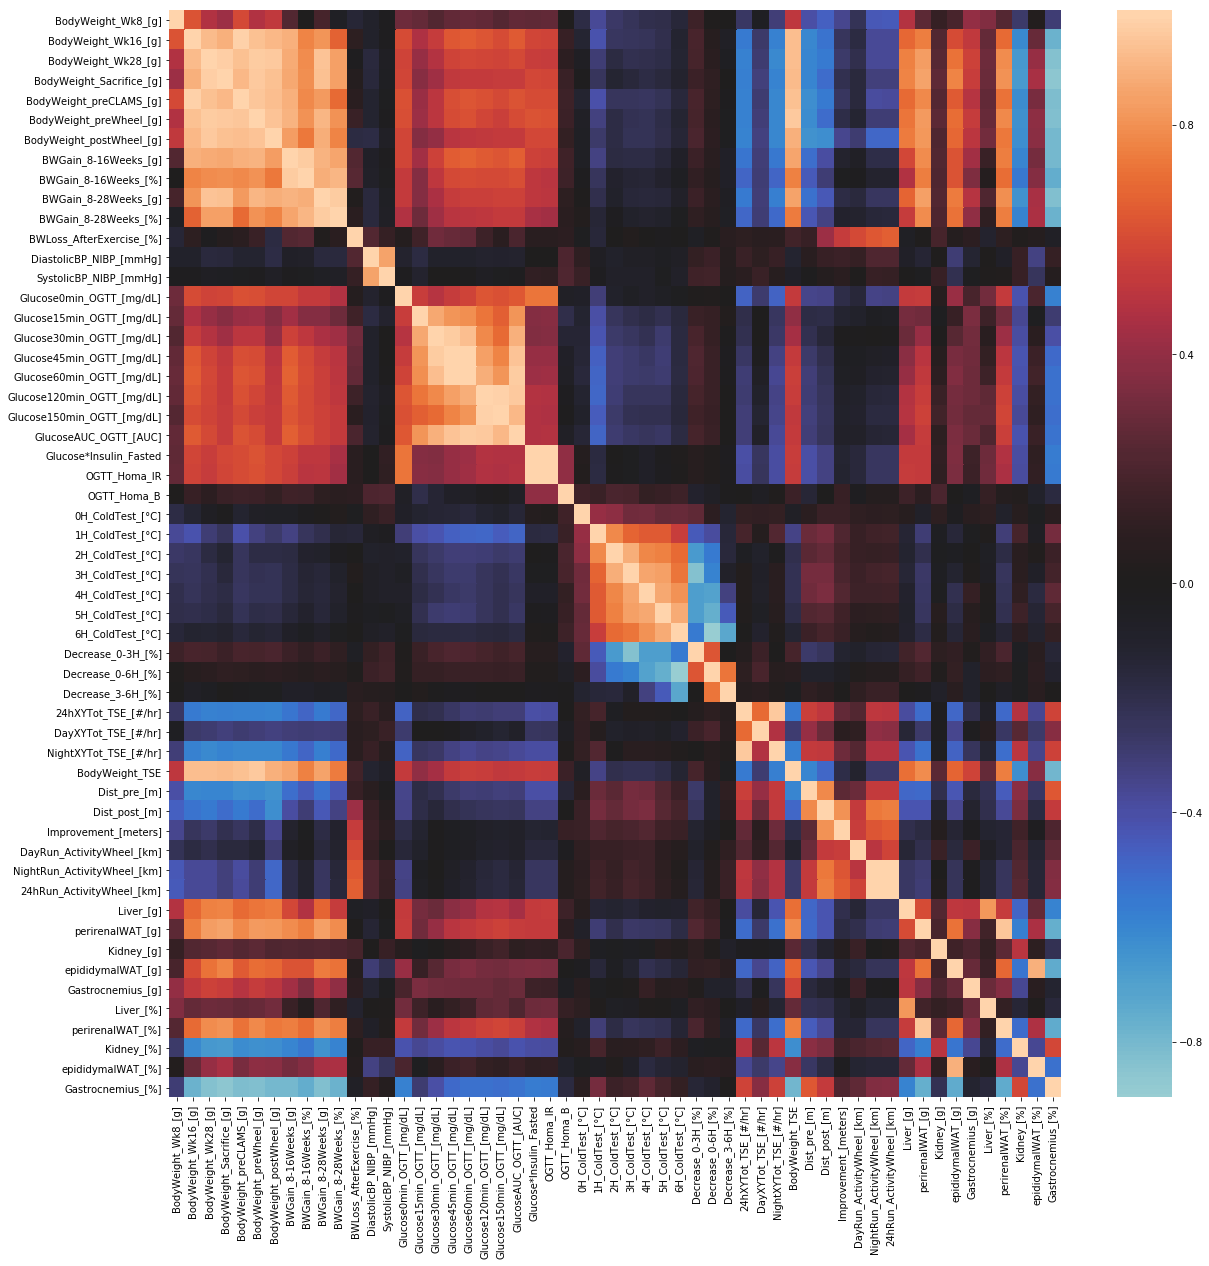

In [23]:
#Diet was added in the plots above as color label

#This is another version, this time with a heatmap which is centered around 0
fig, ax = plt.subplots(figsize=(20,20)) 
ax = sns.heatmap(data_standardized_df.iloc[:,:-1].corr(), xticklabels=True, yticklabels=True, center = 0)
